# Comparison with Geant4

While nrCascadeSim has overlap with the scope of [Geant4](doi.org/10.1016/S0168-9002(03)01368-8), we propose that nrCascadeSim produces better results for nuclear recoils because it is built specifically to handle them, while Geant4 is a much more general package. This notebook is intended to let the user form their own opinions about how the two packages compare.

# Data Generation

## nrCascadeSim
The nrCascadeSim data was generated by running the realizeCascades command. For example, the silicon data was obtained using:
```
realizeCascades -n 10000 -o example-usecase/data/Sifile.root levelfiles/Si28_ngam_all_cascades_rfmt_sorted.txt
```

## Geant4
The Geant4 data was generated by running a found at https://github.com/villano-lab/G4PhysicsTesting. The silicon data was obtained starting with:
```
./NeutReflectometry -src cascade -d -8 -set 2 -ngen 100000 -otype ascii -usestringlabel SiCapture -nomac -loc .
```
All non-NR data was pruned using the `prune.py` script found in this directory's `python` subdirectory:
```
python3 prune.py ~/packages/G4PhysicsTesting/NROUT/Neut
ReflectDiag12_Sourcecascade_neutron_NeCapture_000_0??.txt Sifile.txt
```
And the files with multi-step events had these events 'smashed' into one line using commands like the following:
```
cat Arfile.txt |awk 'BEGIN{ev=0;FS=","}{if($2!="EV"){ev=$1; d3[ev]+=$7;a[ev]=$1;b[ev]=$2;c[ev]=$3;d[ev]=$4;e[ev]=$5;f[ev]=$6;h[ev]=$8}}END{for(i in d3){print a[i]","b[i]","c[i]","d[i]","e[i]","f[i]","d3[i]","h[i]}}' |sort -h -t "," |awk 'BEGIN{print ",EV,TS,P,Type,E1,D3,time1"}{print $0}' > Arfile_summed.txt 

 cat Arfile.txt |awk 'BEGIN{ev=0;FS=",";off=0;prev=0}{if($2!="EV"){prev=$1; if($1<prev){off+=ev} ev=$1+off; d3[ev]+=$7;a[ev]=$1;b[ev]=$2;c[ev]=$3;d[ev]=$4;e[ev]=$5;f[ev]=$6;h[ev]=$8}}END{for(i in d3){print i","b[i]","c[i]","d[i]","e[i]","f[i]","d3[i]","h[i]}}' |sort -h -t "," |awk 'BEGIN{print ",EV,TS,P,Type,E1,D3,time1"}{print $0}' > Arfile_summed.txt 
```
(see https://github.com/villano-lab/G4PhysicsTesting/blob/feature/output-for-comparison/python/data/awk_commands.txt).

In [1]:
#Lib Import

#"Standard" Libraries
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
plt.style.use('standard.mplstyle')
from matplotlib.lines import Line2D
#from hashlib import md5
#Custom libraries
import sys                   #Set up to import custom libraries
sys.path.append('./python')  #From `python` directory
from hist import histogramable as h #Custom library for applying yield models and formatting to use histogram function

dict_keys(['xx', 'yy', 'ex', 'ey'])


In [2]:
#Build stuff!

#Select a file.
Sirootfile = './data/Sifile.root'
Sitxtfile = pd.read_csv('./data/Sifile_summed.txt')

#Apply yields and format to display as histogram later.
nrcs = np.ndarray.flatten(np.asarray(h(Sirootfile,model=None,resolution=None)[0]))
G4 = Sitxtfile['D3']*1e6

#Define a function for formatting the y-axis ticks with scientific notation.
#From https://stackoverflow.com/questions/31517156/adjust-exponent-text-after-setting-scientific-limits-on-matplotlib-axis
def format_exponent(ax, axis='y'):

    # Change the ticklabel format to scientific format
    ax.ticklabel_format(axis=axis, style='sci', scilimits=(-2, 2))

    # Get the appropriate axis
    if axis == 'y':
        ax_axis = ax.yaxis
        x_pos = 0.0
        y_pos = 1.0
        horizontalalignment='left'
        verticalalignment='bottom'
    else:
        ax_axis = ax.xaxis
        x_pos = 1.0
        y_pos = -0.05
        horizontalalignment='right'
        verticalalignment='top'

    # Run plt.tight_layout() because otherwise the offset text doesn't update
    plt.tight_layout()

    # Get the offset value
    offset = ax_axis.get_offset_text().get_text()

    # If there's an offset,
    if len(offset) > 0:
        # Get that exponent value and change it into latex format
        minus_sign = u'\u2212'
        expo = float(offset.replace(minus_sign, '-').split('e')[-1])
        offset_text = r'x$\mathregular{10^{%d}}$' %expo

        # Turn off the offset text that's calculated automatically
        ax_axis.offsetText.set_visible(False)

        # Add in a text box at the top of the y axis
        ax.text(x_pos, y_pos, offset_text, transform=ax.transAxes,
               horizontalalignment=horizontalalignment,
               verticalalignment=verticalalignment,fontsize=30)
    return ax

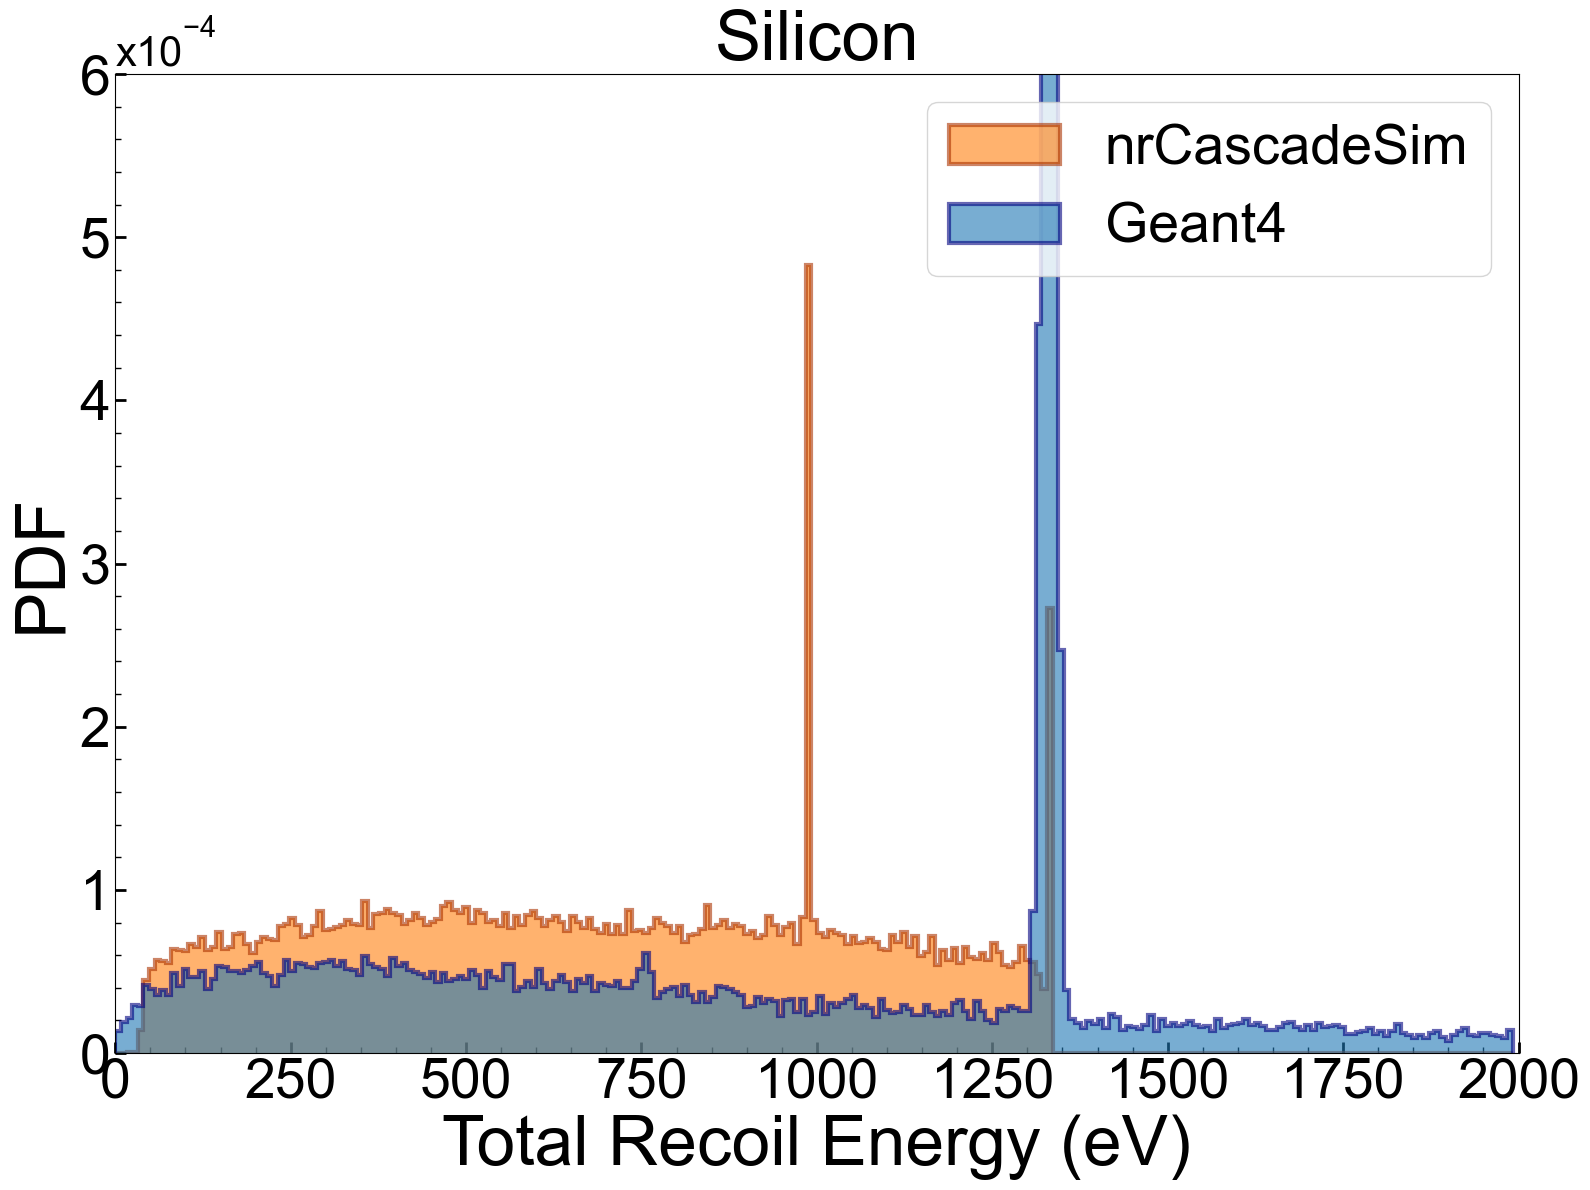

In [3]:
#Plotting!

#Set up to plot
fig, ax = plt.subplots(figsize=(16,12))

#Set up histogram binning.
binsize = 8 #bin width in eVee
maxrange = 2000
bins = np.arange(0,maxrange,binsize)

#Plot data
plt.hist(nrcs,alpha=0.6,label='nrCascadeSim',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='#a30',color='C1')
plt.hist(G4,alpha=0.6,label='Geant4',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='navy',color='C0')

#Label Axes
plt.xlabel(r"Total Recoil Energy (eV)",fontsize=50)
plt.ylabel("PDF",fontsize=50)#Counts/(total counts * bin width)")

#Format axis ticks
ax = format_exponent(ax, axis='y')
ax.tick_params(axis='both',which='major',labelsize=40)

#Define plotting region
#plt.xlim([0,500])
plt.ylim([5e-13,6e-3]) #Make corner less awkward. Smallest starting value that will make the extra 0 go away
plt.xlim([0,maxrange])

#Legend Formatting
nrcsPatch = mpatch.Patch(facecolor='C1',edgecolor='#a30',linewidth=3,label='nrCascadeSim',alpha=0.6)
g4Patch = mpatch.Patch(facecolor='C0',edgecolor='navy',linewidth=3,label='Geant4',alpha=0.6)

#Display everything
plt.legend(handles=[nrcsPatch,g4Patch],fontsize=40)
plt.title('Silicon',fontsize=50)
plt.tight_layout()
plt.savefig('plots/Silicon_comparison.png')
plt.savefig('plots/Silicon_comparison.pdf')
plt.show()

In [4]:
#Build stuff!

#Select a file.
Gerootfile = './data/Gefile.root'
Getxtfile = pd.read_csv('./data/Gefile_summed.txt')

#Apply yields and format to display as histogram later.
nrcs = np.ndarray.flatten(np.asarray(h(Gerootfile,model=None,material='Ge')[0]))
G4 = Getxtfile['D3']*1e6 #MeV to eV

#Define a function for formatting the y-axis ticks with scientific notation.
#From https://stackoverflow.com/questions/31517156/adjust-exponent-text-after-setting-scientific-limits-on-matplotlib-axis
def format_exponent(ax, axis='y'):

    # Change the ticklabel format to scientific format
    ax.ticklabel_format(axis=axis, style='sci', scilimits=(-2, 2))

    # Get the appropriate axis
    if axis == 'y':
        ax_axis = ax.yaxis
        x_pos = 0.0
        y_pos = 1.0
        horizontalalignment='left'
        verticalalignment='bottom'
    else:
        ax_axis = ax.xaxis
        x_pos = 1.0
        y_pos = -0.05
        horizontalalignment='right'
        verticalalignment='top'

    # Run plt.tight_layout() because otherwise the offset text doesn't update
    plt.tight_layout()

    # Get the offset value
    offset = ax_axis.get_offset_text().get_text()

    # If there's an offset,
    if len(offset) > 0:
        # Get that exponent value and change it into latex format
        minus_sign = u'\u2212'
        expo = float(offset.replace(minus_sign, '-').split('e')[-1])
        offset_text = r'x$\mathregular{10^{%d}}$' %expo

        # Turn off the offset text that's calculated automatically
        ax_axis.offsetText.set_visible(False)

        # Add in a text box at the top of the y axis
        ax.text(x_pos, y_pos, offset_text, transform=ax.transAxes,
               horizontalalignment=horizontalalignment,
               verticalalignment=verticalalignment,fontsize=30)
    return ax

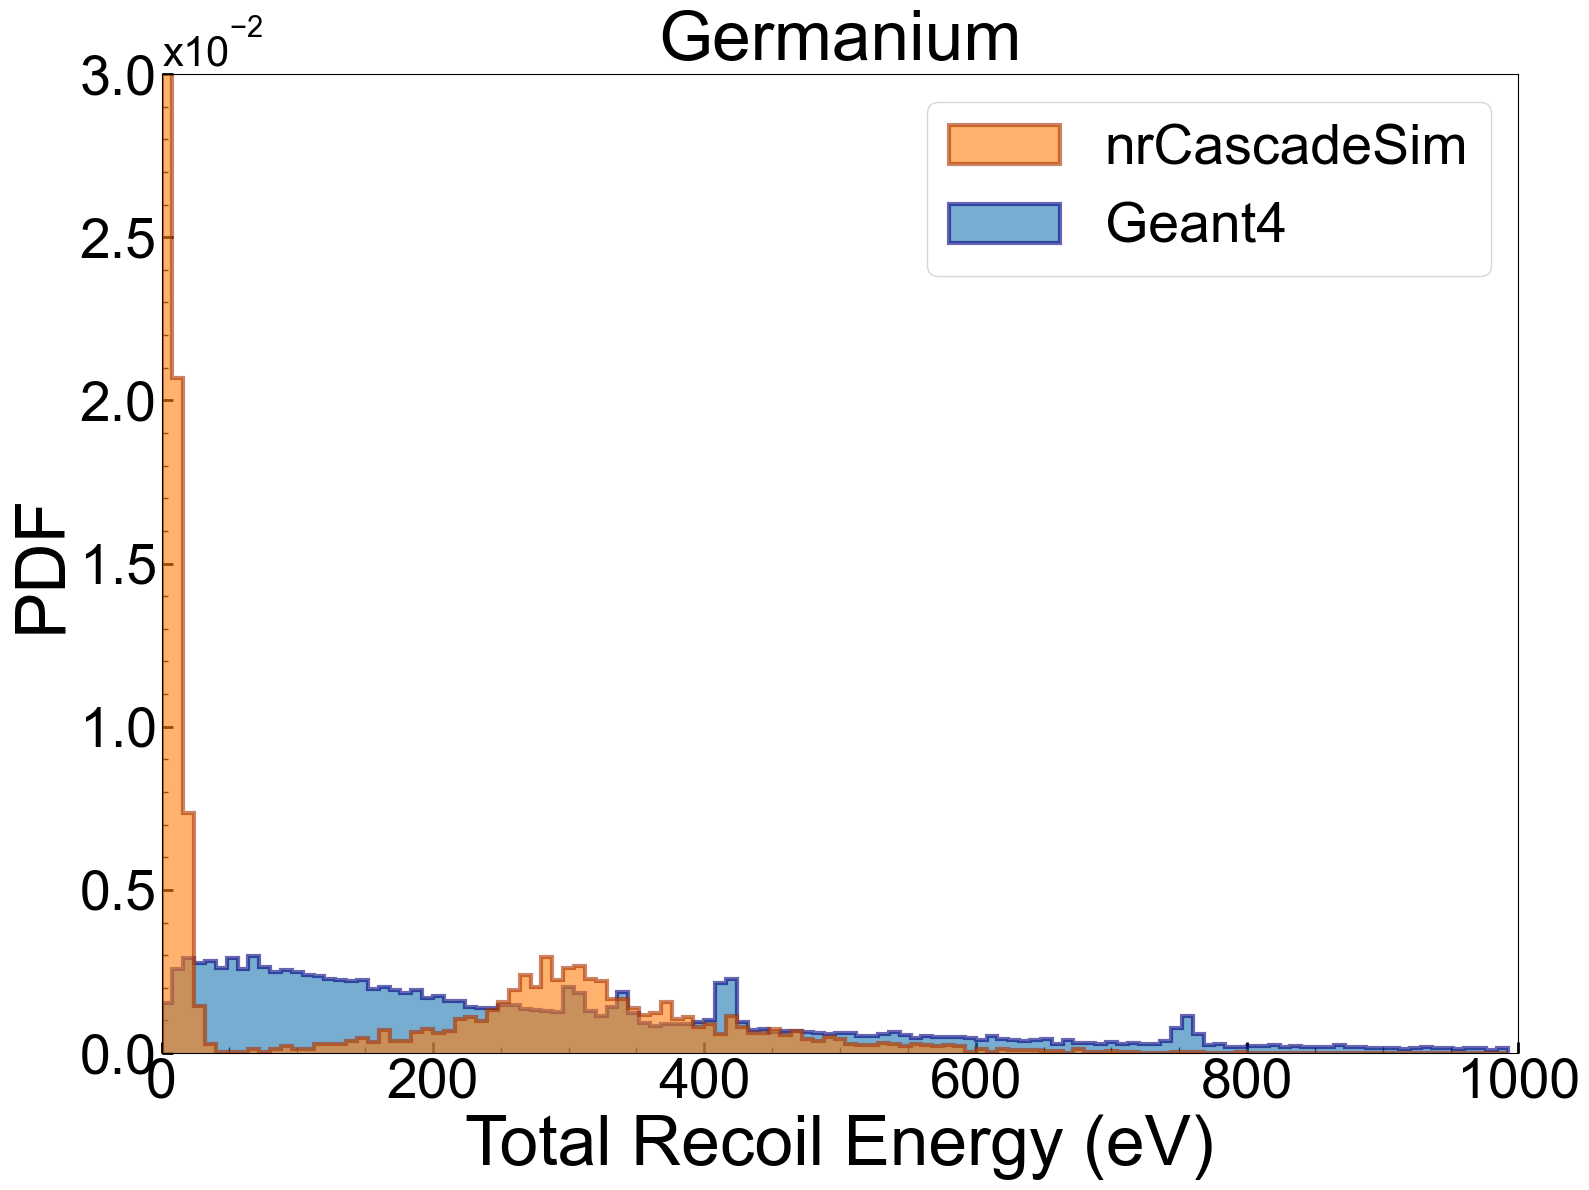

In [5]:
#Plotting!

#Set up to plot
fig, ax = plt.subplots(figsize=(16,12))

#Set up histogram binning. #Just keeping previous binsize.
#binsize = 8 #bin width in eVee
maxrange = 1000
bins = np.arange(0,maxrange,binsize)

#Plot data
plt.hist(G4,alpha=0.6,label='Geant4',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='navy',color='C0')
plt.hist(nrcs,alpha=0.6,label='nrCascadeSim',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='#a30',color='C1')

#Label Axes
plt.xlabel(r"Total Recoil Energy (eV)",fontsize=50)
plt.ylabel("PDF",fontsize=50)#Counts/(total counts * bin width)")

#Format axis ticks
ax = format_exponent(ax, axis='y')
ax.tick_params(axis='both',which='major',labelsize=40)

#Define plotting region
#plt.xlim([0,200])
plt.ylim([5e-13,3e-2]) #Make corner less awkward. Smallest starting value that will make the extra 0 go away
plt.xlim([0,maxrange])

#Legend Formatting
nrcsPatch = mpatch.Patch(facecolor='C1',edgecolor='#a30',linewidth=3,label='nrCascadeSim',alpha=0.6)
g4Patch = mpatch.Patch(facecolor='C0',edgecolor='navy',linewidth=3,label='Geant4',alpha=0.6)

#Display everything
plt.legend(handles=[nrcsPatch,g4Patch],fontsize=40)
plt.title('Germanium',fontsize=50)
plt.tight_layout()
plt.savefig('plots/Germanium_comparison.png')
plt.show()

In [6]:
#Build stuff!

#Select a file.
Nerootfile = './data/Nefile.root'
Netxtfile = pd.read_csv('./data/Nefile_summed.txt')

#Apply yields and format to display as histogram later.
nrcs = np.ndarray.flatten(np.asarray(h(Nerootfile,model=None,resolution=None)[0]))
G4 = Netxtfile['D3']*1e6

#Define a function for formatting the y-axis ticks with scientific notation.
#From https://stackoverflow.com/questions/31517156/adjust-exponent-text-after-setting-scientific-limits-on-matplotlib-axis
def format_exponent(ax, axis='y'):

    # Change the ticklabel format to scientific format
    ax.ticklabel_format(axis=axis, style='sci', scilimits=(-2, 2))

    # Get the appropriate axis
    if axis == 'y':
        ax_axis = ax.yaxis
        x_pos = 0.0
        y_pos = 1.0
        horizontalalignment='left'
        verticalalignment='bottom'
    else:
        ax_axis = ax.xaxis
        x_pos = 1.0
        y_pos = -0.05
        horizontalalignment='right'
        verticalalignment='top'

    # Run plt.tight_layout() because otherwise the offset text doesn't update
    plt.tight_layout()

    # Get the offset value
    offset = ax_axis.get_offset_text().get_text()

    # If there's an offset,
    if len(offset) > 0:
        # Get that exponent value and change it into latex format
        minus_sign = u'\u2212'
        expo = float(offset.replace(minus_sign, '-').split('e')[-1])
        offset_text = r'x$\mathregular{10^{%d}}$' %expo

        # Turn off the offset text that's calculated automatically
        ax_axis.offsetText.set_visible(False)

        # Add in a text box at the top of the y axis
        ax.text(x_pos, y_pos, offset_text, transform=ax.transAxes,
               horizontalalignment=horizontalalignment,
               verticalalignment=verticalalignment,fontsize=30)
    return ax

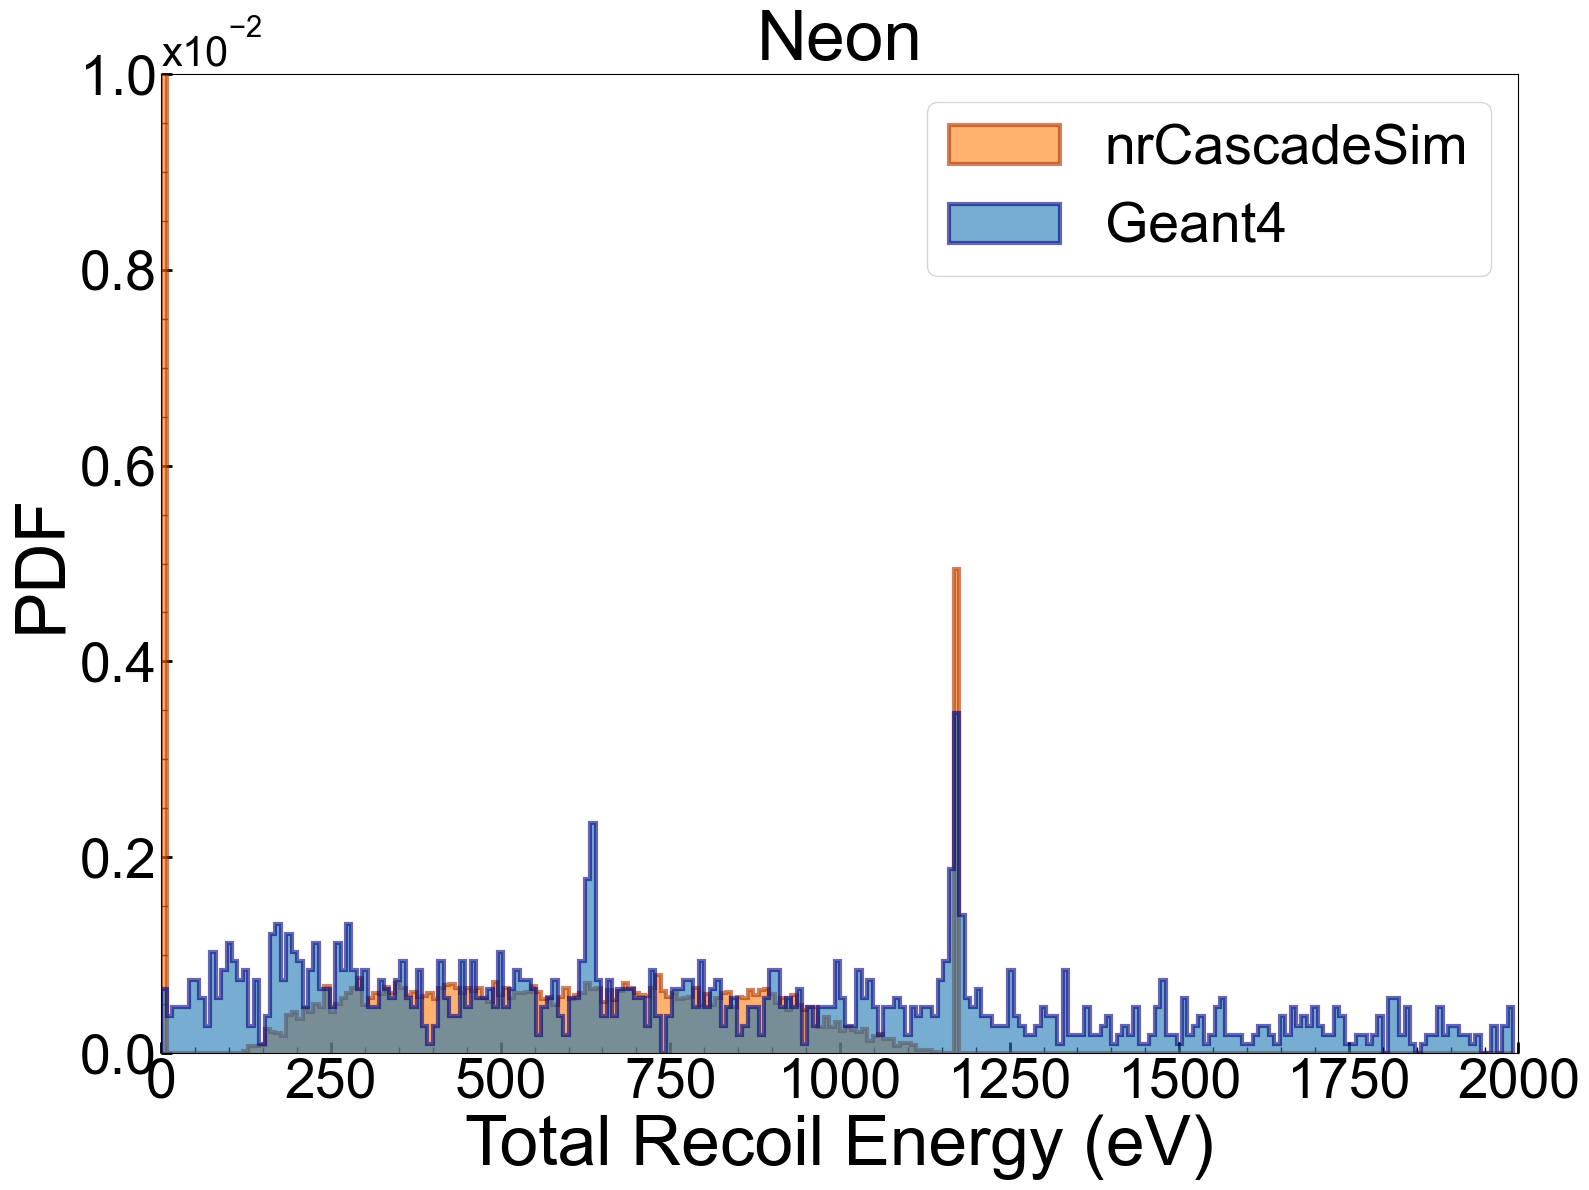

In [7]:
#Plotting!

#Set up to plot
fig, ax = plt.subplots(figsize=(16,12))

#Set up histogram binning.
#binsize = 8 #bin width in eVee
maxrange = 2000
bins = np.arange(0,maxrange,binsize)

#Plot data
plt.hist(nrcs,alpha=0.6,label='nrCascadeSim',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='#a30',color='C1')
plt.hist(G4,alpha=0.6,label='Geant4',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='navy',color='C0')

#Label Axes
plt.xlabel(r"Total Recoil Energy (eV)",fontsize=50)
plt.ylabel("PDF",fontsize=50)#Counts/(total counts * bin width)")

#Format axis ticks
ax = format_exponent(ax, axis='y')
ax.tick_params(axis='both',which='major',labelsize=40)

#Define plotting region
#plt.xlim([0,400])
plt.ylim([5e-13,1e-2]) #Make corner less awkward. Smallest starting value that will make the extra 0 go away
plt.xlim([0,maxrange])

#Legend Formatting
nrcsPatch = mpatch.Patch(facecolor='C1',edgecolor='#a30',linewidth=3,label='nrCascadeSim',alpha=0.6)
g4Patch = mpatch.Patch(facecolor='C0',edgecolor='navy',linewidth=3,label='Geant4',alpha=0.6)

#Display everything
plt.legend(handles=[nrcsPatch,g4Patch],fontsize=40)
plt.title('Neon',fontsize=50)
plt.tight_layout()
plt.savefig('plots/Neon_comparison.png')
plt.show()

In [8]:
#Build stuff!

#Select a file.
Arrootfile = './data/Arfile.root'
Artxtfile = pd.read_csv('./data/Arfile_summed.txt')

#Apply yields and format to display as histogram later.
nrcs = np.ndarray.flatten(np.asarray(h(Arrootfile,model=None)[0]))
G4 = Artxtfile['D3']*1e6

#Define a function for formatting the y-axis ticks with scientific notation.
#From https://stackoverflow.com/questions/31517156/adjust-exponent-text-after-setting-scientific-limits-on-matplotlib-axis
def format_exponent(ax, axis='y'):

    # Change the ticklabel format to scientific format
    ax.ticklabel_format(axis=axis, style='sci', scilimits=(-2, 2))

    # Get the appropriate axis
    if axis == 'y':
        ax_axis = ax.yaxis
        x_pos = 0.0
        y_pos = 1.0
        horizontalalignment='left'
        verticalalignment='bottom'
    else:
        ax_axis = ax.xaxis
        x_pos = 1.0
        y_pos = -0.05
        horizontalalignment='right'
        verticalalignment='top'

    # Run plt.tight_layout() because otherwise the offset text doesn't update
    plt.tight_layout()

    # Get the offset value
    offset = ax_axis.get_offset_text().get_text()

    # If there's an offset,
    if len(offset) > 0:
        # Get that exponent value and change it into latex format
        minus_sign = u'\u2212'
        expo = float(offset.replace(minus_sign, '-').split('e')[-1])
        offset_text = r'x$\mathregular{10^{%d}}$' %expo

        # Turn off the offset text that's calculated automatically
        ax_axis.offsetText.set_visible(False)

        # Add in a text box at the top of the y axis
        ax.text(x_pos, y_pos, offset_text, transform=ax.transAxes,
               horizontalalignment=horizontalalignment,
               verticalalignment=verticalalignment,fontsize=30)
    return ax

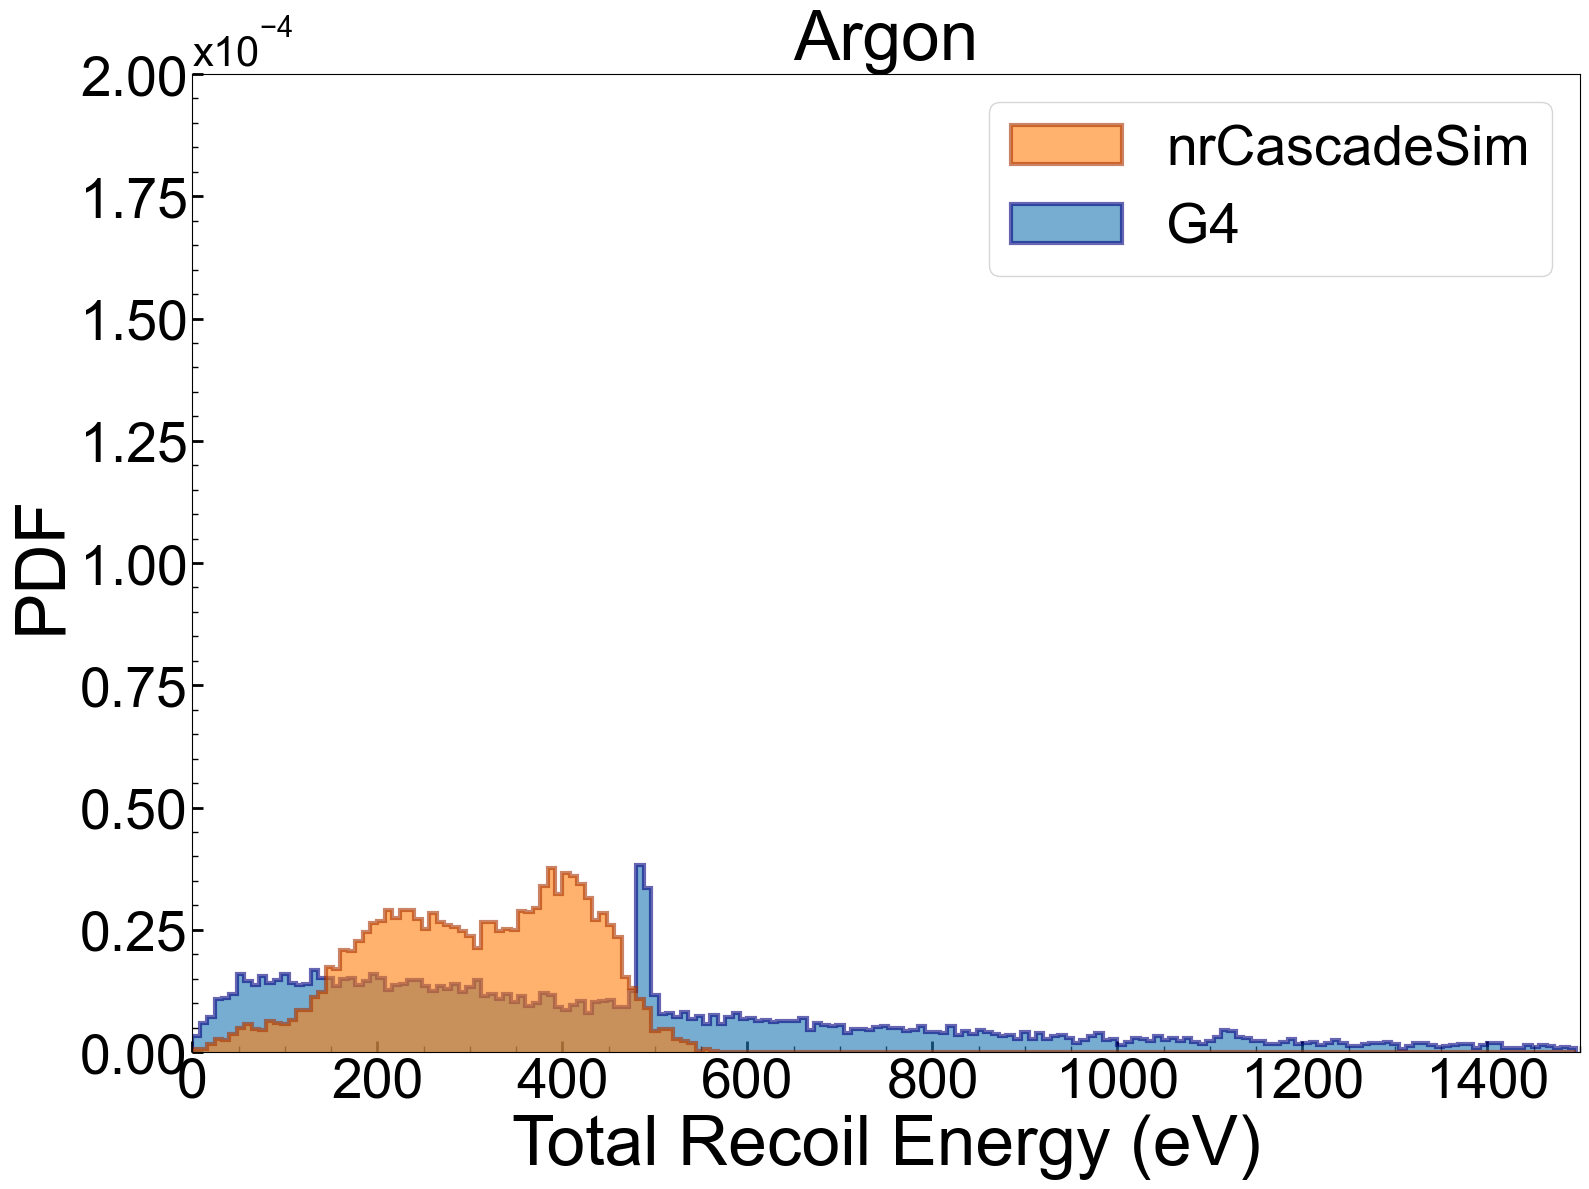

In [9]:
#Plotting!

#Set up to plot
fig, ax = plt.subplots(figsize=(16,12))

#Set up histogram binning.
#binsize = 8 #bin width in eVee
maxrange = 1500
bins = np.arange(0,maxrange,binsize)

#Plot data
plt.hist(G4,alpha=0.6,label='Geant4',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='navy',color='C0')
plt.hist(nrcs,alpha=0.6,label='nrCascadeSim',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='#a30',color='C1')

#Label Axes
plt.xlabel(r"Total Recoil Energy (eV)",fontsize=50)
plt.ylabel("PDF",fontsize=50)#Counts/(total counts * bin width)")

#Format axis ticks
ax = format_exponent(ax, axis='y')
ax.tick_params(axis='both',which='major',labelsize=40)

#Define plotting region
#plt.xlim([0,175])
plt.ylim([5e-13,2e-2]) #Make corner less awkward. Smallest starting value that will make the extra 0 go away
plt.xlim([0,maxrange])

#Legend Formatting
nrcsPatch = mpatch.Patch(facecolor='C1',edgecolor='#a30',linewidth=3,label='nrCascadeSim',alpha=0.6)
g4Patch = mpatch.Patch(facecolor='C0',edgecolor='navy',linewidth=3,label='G4',alpha=0.6)

#Display everything
plt.legend(handles=[nrcsPatch,g4Patch],fontsize=40)
plt.title('Argon',fontsize=50)
plt.tight_layout()
plt.savefig('plots/Argon_comparison.png')
plt.show()

# Number of Multi-Step Events
Below are stats on the portion of events in each file that have multiple steps. 
This is relevant for cases where one might be applying a nonlinear yield, in which case it is important to be able to apply the yield to each step's energy before the steps are combined into a single event.

In [10]:
#nrCascadeSim
#---Si
a = uproot.open(Sirootfile)['cascade']
allevents = a['delE'].array()
singlestep = [entry for entry in allevents if len(entry)==1]
nrcsSi = len(singlestep)/len(allevents)
#---Ge
a = uproot.open(Gerootfile)['cascade']
allevents = a['delE'].array()
singlestep = [entry for entry in allevents if len(entry)==1]
nrcsGe = len(singlestep)/len(allevents)
#---Ne
a = uproot.open(Nerootfile)['cascade']
allevents = a['delE'].array()
singlestep = [entry for entry in allevents if len(entry)==1]
nrcsNe = len(singlestep)/len(allevents)
#---Ar
a = uproot.open(Arrootfile)['cascade']
allevents = a['delE'].array()
singlestep = [entry for entry in allevents if len(entry)==1]
nrcsAr = len(singlestep)/len(allevents)
#Geant4
#---Si
allevents = Sitxtfile['EV']
diff = len(pd.read_csv('./data/Sifile.txt')['EV'])-len(allevents) #Number of multi-step is <= how many lines were cut when condensing the files
G4Si = 1 - diff/len(allevents)
#---Ge
allevents = Getxtfile['EV']
diff = len(pd.read_csv('./data/Gefile.txt')['EV'])-len(allevents) #Number of multi-step is <= to how many lines were cut when condensing the files
G4Ge = 1 - diff/len(allevents)
#---Ne
allevents = Netxtfile['EV']
diff = len(pd.read_csv('./data/Nefile.txt')['EV'])-len(allevents) #Number of multi-step is <= to how many lines were cut when condensing the files
G4Ne = 1 - diff/len(allevents)
#---Ar
allevents = Artxtfile['EV']
diff = len(pd.read_csv('./data/Arfile.txt')['EV'])-len(allevents) #Number of multi-step is <= to how many lines were cut when condensing the files
G4Ar = 1 - diff/len(allevents)

print('Percentage of events that are single-step')
print('=========================================')
print('     nrCascadeSim   |       Geant4       ')
print('   --------------------------------------')
print('Si|      {nrcs:4.2%}      |       \u2265{G4:02.2%}'.format(nrcs=nrcsSi,G4=G4Si))
print('Ge|      {nrcs:4.2%}      |       \u2265{G4:02.2%}'.format(nrcs=nrcsGe,G4=G4Ge))
print('Ne|      {nrcs:4.2%}      |       \u2265{G4:02.2%}'.format(nrcs=nrcsNe,G4=G4Ne))
print('Ar|      {nrcs:4.2%}      |       \u2265{G4:02.2%}'.format(nrcs=nrcsAr,G4=G4Ar))

Percentage of events that are single-step
     nrCascadeSim   |       Geant4       
   --------------------------------------
Si|      2.16%      |       ≥92.73%
Ge|      2.80%      |       ≥92.95%
Ne|      6.27%      |       ≥99.58%
Ar|      0.00%      |       ≥94.20%
